In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import importlib
import climbing_ticks_helper as helper
importlib.reload(helper)
pd.set_option('display.expand_frame_repr', False) # display full data in terminal
%matplotlib inline


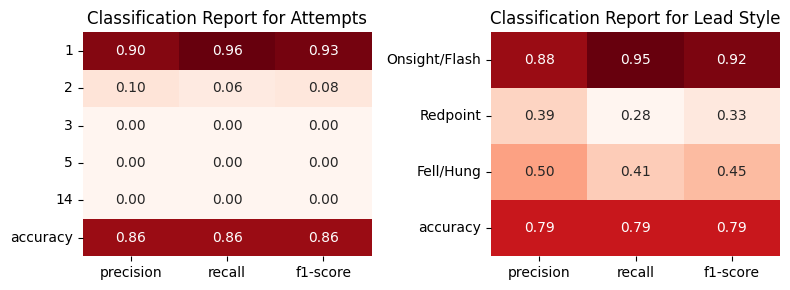

Using Random Forest Classifier:
We got 45 Lead Style predictions wrong out of 213 total predictions.
We got 30 Attempts predictions wrong out of 213 total predictions.


In [2]:

df = pd.read_csv('/app/csv_files/model_ready_ticks.csv')

# first take at a Random Forest model:
X = df.drop(columns=['Attempts', 'Lead Style'])
y = df[['Attempts', 'Lead Style']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns)

# compute accuracy, recall, precision, f1 score for multi class predictions
helper.print_classification_report(y_test, y_pred_df)

df_pretty = pd.read_csv('/app/csv_files/grouped_ticks.csv')
df_pretty = df_pretty[df_pretty['RouteID'].isin(X_test['RouteID'])].set_index('RouteID').loc[X_test['RouteID']].reset_index()
df_combined = helper.combine_predictions_with_data(df_pretty, y_pred_df)

# print all rows that got Lead Style wrong
wrong_preds_style = df_combined[df_combined['Lead Style'] != df_combined['Predicted Lead Style']]
wrong_preds_attempts = df_combined[df_combined['Attempts'] != df_combined['Predicted Attempts']]
print("Using Random Forest Classifier:")
print(f'We got {len(wrong_preds_style)} Lead Style predictions wrong out of {y_pred_df.shape[0]} total predictions.')
print(f'We got {len(wrong_preds_attempts)} Attempts predictions wrong out of {y_pred_df.shape[0]} total predictions.')

combined_df = helper.combine_predictions_with_data(df_pretty, y_pred_df)


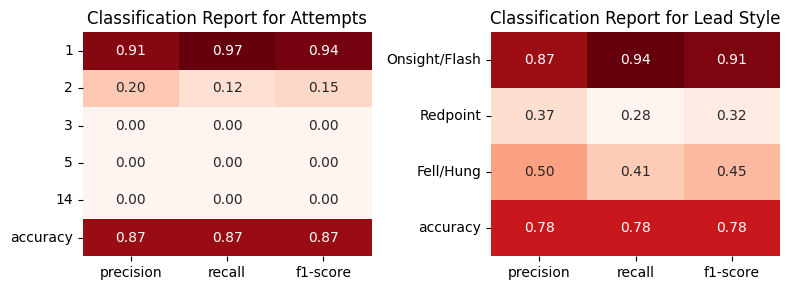

using MultiOutputClassifier:
We got 47 Lead Style predictions wrong out of 213 total predictions.
We got 27 Attempts predictions wrong out of 213 total predictions.


In [3]:
# Use a MultiOutputClassifier to predict both Attempts and Lead Style

moc=MultiOutputClassifier(RandomForestClassifier(n_estimators=100))
moc.fit(X_train, y_train)
y_pred_moc = moc.predict(X_test)

helper.print_classification_report(y_test, pd.DataFrame(y_pred_moc, columns=y_test.columns))

moc_df_combined = helper.combine_predictions_with_data(df_pretty, pd.DataFrame(y_pred_moc, columns=y_test.columns))

wrong_preds_style = moc_df_combined[moc_df_combined['Lead Style'] != moc_df_combined['Predicted Lead Style']]
wrong_preds_attempts = moc_df_combined[moc_df_combined['Attempts'] != moc_df_combined['Predicted Attempts']]
print("using MultiOutputClassifier:")
print(f'We got {len(wrong_preds_style)} Lead Style predictions wrong out of {y_pred_df.shape[0]} total predictions.')
print(f'We got {len(wrong_preds_attempts)} Attempts predictions wrong out of {y_pred_df.shape[0]} total predictions.')

In [4]:
# probability predictions:
proba_predictions = rf.predict_proba(X_test)
combined_df_proba = helper.combine_proba_predictions_with_data(df_pretty, proba_predictions)
combined_df_proba.head(10)

,Route,RouteID,Date,Route Type,Alpine,Safety,Avg Stars,Pitches,Rating,OS/F pred,RP pred,F/H pred,Lead Style,1 Attempt pred,2 Attempts pred,3+ Attempts pred,Attempts
0,Poker Face Alice,105862062,2022-07-09,Sport,0.0,G,3.2,1,5.12b,0.10,0.67,0.23,Onsight/Flash,0.31,0.51,0.18,1
1,Tierra Del Fuego,105763815,2022-10-22,Sport,0.0,G,2.6,1,5.11b,0.81,0.15,0.04,Onsight/Flash,0.88,0.12,0.00,1
2,The Shaft,106207686,2020-07-26,Sport,0.0,G,3.8,1,5.12b,0.19,0.22,0.59,Fell/Hung,0.76,0.21,0.03,1
3,Diamonds and Rain,106517680,2018-07-12,Sport,0.0,G,3.5,1,5.12a,0.41,0.42,0.17,Redpoint,0.76,0.15,0.09,3
4,The Naked Hedge,105763197,2018-08-08,Sport,0.0,G,2.5,1,5.10,0.89,0.06,0.05,Onsight/Flash,0.96,0.04,0.00,1
5,Stone Hinge,107428294,2022-02-14,Sport,0.0,G,4.0,1,5.12d,0.01,0.26,0.73,Fell/Hung,0.49,0.48,0.03,1
6,The Pollinator,105757681,2018-07-07,Sport,0.0,G,2.3,1,5.12a,0.28,0.26,0.46,Fell/Hung,0.88,0.09,0.03,1
7,Ripped,106363085,2021-12-25,Sport,0.0,G,2.7,1,5.10b,1.00,0.00,0.00,Onsight/Flash,1.00,0.00,0.00,1
8,Center Route,105748816,2023-02-19,Trad,0.0,G,3.9,2,5.9+,0.50,0.22,0.28,Fell/Hung,0.85,0.13,0.02,1
9,Backdoor Man,112095476,2021-08-28,Sport,0.0,G,3.5,1,5.12a,0.03,0.21,0.76,Redpoint,0.78,0.13,0.09,2


In [136]:
# TODO:
# * categorize predictions that are close to the correct answer. EG: predicting an Onsight/Flash when the actual is a Redpoint with only 2 attempts isn't that bad. but predicting an Onsight/Flash when the actual is a Fell/Hung with 5 attempts is bad.
# * categorize predictions that thought I would do better, vs predictions that thought I would do worse
